<a href="https://colab.research.google.com/github/Z4UC/Controller/blob/main/MPC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Zaman: 0.00s | Açı: -0.00° | Sağ Ağırlık: 35.00kg
Zaman: 0.01s | Açı: -0.01° | Sağ Ağırlık: 35.00kg
bosss
Zaman: 0.02s | Açı: -0.02° | Sağ Ağırlık: 33.70kg
bosss
Zaman: 0.03s | Açı: -0.04° | Sağ Ağırlık: 32.51kg
!!!!!!!!pred_x:  1
!!!!!!!!Sol agırlik:  33
bosss
Zaman: 0.04s | Açı: -0.05° | Sağ Ağırlık: 31.10kg
!!!!!!!!pred_x:  -32
!!!!!!!!Sol agırlik:  30
bosss
Zaman: 0.05s | Açı: -0.07° | Sağ Ağırlık: 29.58kg
!!!!!!!!pred_x:  5394
!!!!!!!!Sol agırlik:  30
bosss
Zaman: 0.06s | Açı: -0.08° | Sağ Ağırlık: 28.10kg
!!!!!!!!pred_x:  11362
!!!!!!!!Sol agırlik:  30
Son 5 elemanın modu (tamsayı): 30
bosss
Zaman: 0.07s | Açı: -0.09° | Sağ Ağırlık: 26.81kg
!!!!!!!!pred_x:  285
!!!!!!!!Sol agırlik:  30
Son 5 elemanın modu (tamsayı): 30
bosss
Zaman: 0.08s | Açı: -0.10° | Sağ Ağırlık: 25.84kg
!!!!!!!!pred_x:  11
!!!!!!!!Sol agırlik:  30
Son 5 elemanın modu (tamsayı): 30
bosss
Zaman: 0.09s | Açı: -0.10° | Sağ Ağırlık: 25.28kg
x value:  9
pred_x:  9
!!!!!!!!pred_x:  9
!!!!!!!!Sol agırlik:  30
Son 5 e

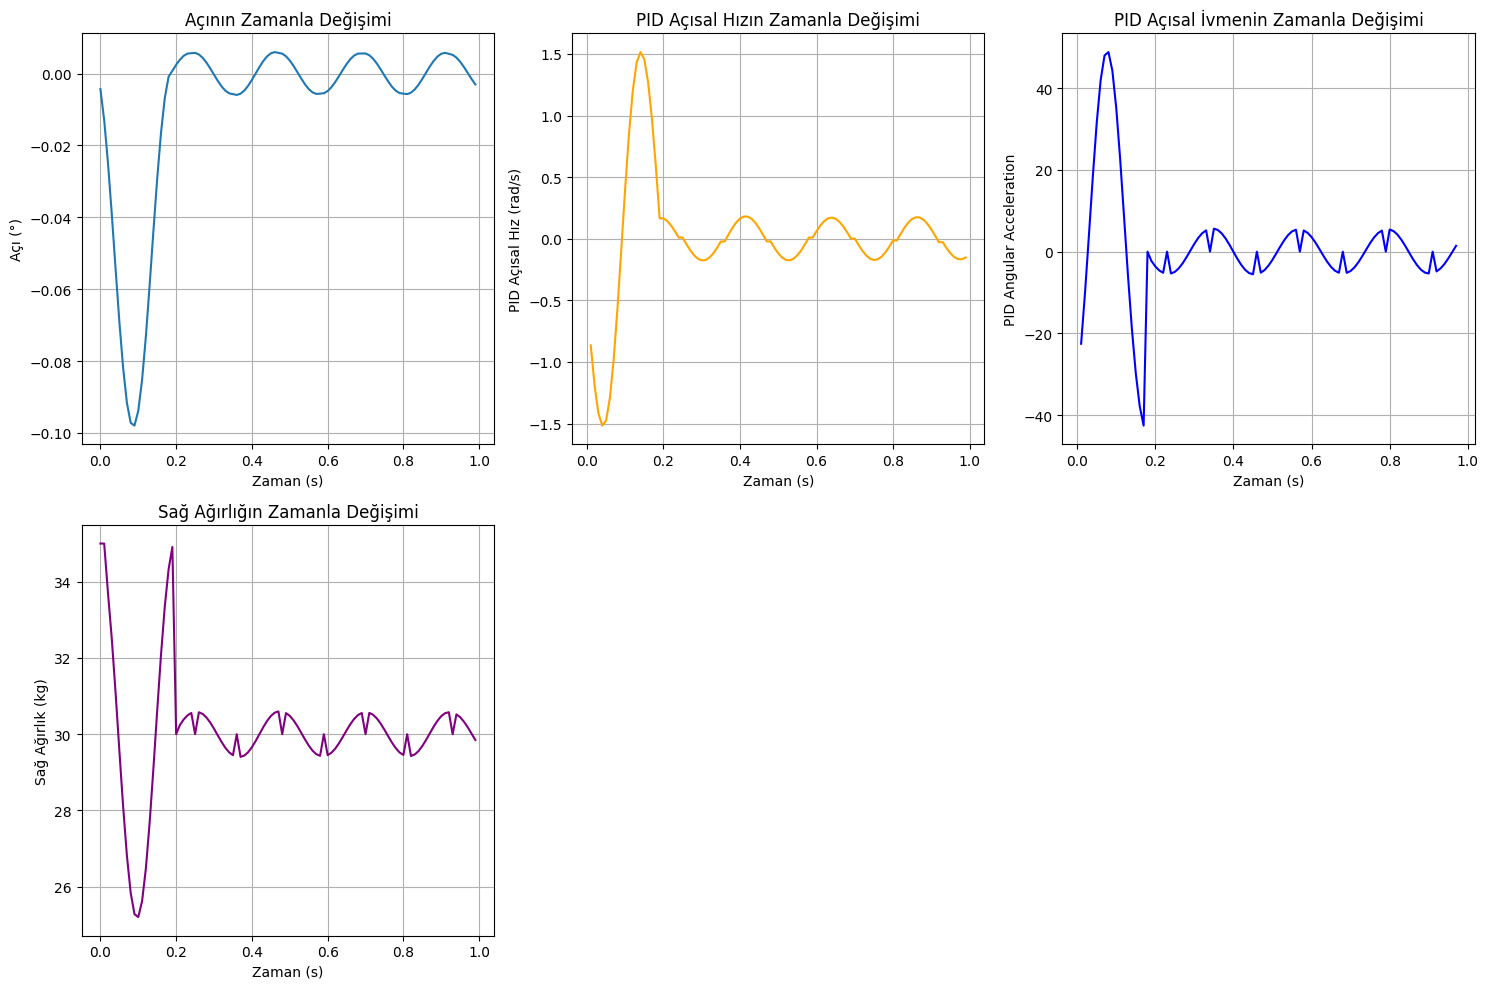

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import statistics

# Sabit parametreler
g = 9.81  # Yerçekimi ivmesi (m/s^2)
length = 2.0  # Tahtravallinin uzunluğu (m)
pivot = length / 2  # Denge noktası
friction = 0.05  # Sürtünme katsayısı
err_arr = []
adj_arr = []
weights_right = []  # Sağ ağırlıkların kaydedileceği liste
weights_right_inv = []

angular_velocities_pid = []  # PID fonksiyonundaki açısal hızlar
angular_accelerations_pid = []  # PID fonksiyonundaki açısal ivmeler

weights_left_inv_arr = [] #interpolation tahmini left weight

back_copy_right_weight = []
copy_right_weight = []
in_right_weight = 0
first_weight_counter = 0
first_velocity_counter = 0
mode_value = None
x_vel_arr = []
pred_x = 99999999999

# PID parametreleri
Kp = 100  # Proportional gain
Ki = 0  # Integral gain
Kd = 0  # Derivative gain

reward = 0





def inv_interpolate(input_values, output_values, target_y):
    # input_values ve output_values uzunluğuna göre n hesapla
    n = len(input_values)  # Burada n sayısını doğrudan kullanıyoruz

    result = 0

    if n > 0:
        # Son 5 input ve output değerini al, ancak bu değerlerin sayısı 5'ten az olabilir
        last_five_input_values = input_values[-4:]  # Son 5 input value
        last_five_sonuc_values = output_values[-4:]  # Son 5 sonuc value
        #print("last_five_input_values: ", last_five_input_values)
        #print("last_five_sonuc_values: ", last_five_sonuc_values)

        # Sonuçları hesaplamak için döngü
        for i in range(len(last_five_input_values)):  # Bu döngü, mevcut input sayısına göre çalışacak
            xi = last_five_input_values[i]
            term = 1

            # Lagrange interpolasyonu
            for j in range(len(last_five_sonuc_values)):
                if j != i:
                    denominator = last_five_sonuc_values[i] - last_five_sonuc_values[j]
                    if denominator == 0:
                        continue  # Zero division hatasını engelle
                    term *= (target_y - last_five_sonuc_values[j]) / denominator

            result += xi * term  # İlgili terimi ekleyin

    return result








def calculate_torque(weight_left, weight_right, length_left, length_right):
    """
    Kuvvet momentlerini hesaplar.
    """
    torque_left = weight_left * g * length_left
    torque_right = weight_right * g * length_right
    return torque_left - torque_right

def weight_pid(angle, weight_right, time_step):
    global err_arr, adj_arr, angular_velocities_pid, angular_accelerations_pid,in_right_weight,first_weight_counter,mode_value,copy_right_weight,back_copy_right_weight,first_velocity_counter,x_vel_arr,pred_x,Kp,Ki,Kd,reward



    copy_right_weight.append(weight_right)



    if first_weight_counter < 1:
        in_right_weight = weight_right
        first_weight_counter += 1











    """
    PID denetleyici fonksiyonu. Açıyı dengelemek için sağ ağırlığı ayarlar.
    """


    # Hata hesaplama
    target_angle = 0  # Hedef açı (denge durumu)
    error = angle - target_angle
    err_arr.append(error)
    x = len(err_arr) - 1

    # PID hesaplamaları
    adjustment = Kp * error  # Proportional kontrol

    # Integral kontrol
    integral_error = sum(err_arr)  # Integral bileşeni, hata birikimi
    adjustment += Ki * integral_error  # Integral bileşeni ekle

    # Derivative kontrol
    if x > 0:  # Derivative hesaplaması için yeterli veri olmalı
        derivative_error = err_arr[x] - err_arr[x-1]  # Türev (hata farkı)
        adjustment += Kd * derivative_error  # Derivative bileşeni ekle

    adj_arr.append(adjustment)





    # Açısal hız hesaplama
    if x > 0:
        angular_pid_velocity = (err_arr[x] - err_arr[x-1]) / time_step
        angular_velocities_pid.append(angular_pid_velocity)
        x_vel_arr.append(x)


    if len(angular_velocities_pid) > 5 and x+3 > inv_interpolate(x_vel_arr, angular_velocities_pid, 0) > x:
        pred_x = round(inv_interpolate(x_vel_arr, angular_velocities_pid, 0))
        print('x value: ',x)
        print("pred_x: ", pred_x)








    # Açısal ivme hesaplama
    if len(angular_velocities_pid) > 2:
        angular_acceleration = (angular_velocities_pid[-1] - angular_velocities_pid[-2]) / time_step
        angular_accelerations_pid.append(angular_acceleration)
        weights_right_inv.append(weight_right)
        print("!!!!!!!!pred_x: ",round(inv_interpolate(x_vel_arr, angular_velocities_pid, 0)))
        print("!!!!!!!!Sol agırlik: ", round(inv_interpolate(weights_right_inv, angular_accelerations_pid, 0)))











    if len(angular_accelerations_pid) > 3:
        weight_left_inv = inv_interpolate(weights_right_inv, angular_accelerations_pid, 0)
        #print("weight_left_inv: ", weight_left_inv)
        if weight_left_inv > 0 and weight_left_inv < 100:
            weights_left_inv_arr.append(weight_left_inv)

        last_five = [round(x) for x in weights_left_inv_arr[-10:]]

        # Mod hesaplama
        if len(last_five) > 0:  # Listenin boş olmadığından emin olun
            #try:
                mode_value = statistics.mode(last_five)
                print("Son 5 elemanın modu (tamsayı):", mode_value)











    if x > 0:

        if pred_x != x or abs(angle) > 0.01:
            print("bosss")
            weight_right = adjustment + in_right_weight
            # Hata değişimlerine göre weight_right'ı ayarlıyoruz


        else:
            # Diğer durumlarda `mode_value` ile sabit tutuyoruz
            print("pred_x ", pred_x)
            weight_right = mode_value
            in_right_weight = weight_right
            reward += 1




    if weight_right is None:
        weight_right = adjustment + in_right_weight  # Varsayılan bir ağırlık atanabilir



    # Sağ ağırlığın minimum sınırını belirleme
    if weight_right < 0:
        weight_right = 0

    return weight_right

def simulate_seesaw(weight_left, weight_right_initial, time_step=0.01, duration=10):
    """
    Tahtravalli simülasyonu.
    """
    angle = 0  # Başlangıç açısı (radyan)
    angular_velocity = 0  # Açısal hız (radyan/s)

    weight_right = weight_right_initial
    length_left = pivot  # Sol tarafın uzunluğu sabit
    length_right = pivot  # Sağ tarafın uzunluğu sabit

    times = np.arange(0, duration, time_step)

    # Grafikleri çizmek için veriler
    angles = []
    angular_velocities = []
    angular_accelerations = []

    for t in times:
        torque = calculate_torque(weight_left, weight_right, length_left, length_right)
        angular_acceleration = torque / (weight_left + weight_right)  # Basit bir kütle momenti modeli

        # Sürtünme etkisi
        angular_acceleration -= friction * angular_velocity

        # Hareket denklemleri
        angular_velocity += angular_acceleration * time_step
        angle += angular_velocity * time_step

        # Açıyı sınırlandır (-45° ile +45° arasında)
        if angle > np.radians(45):
            angle = np.radians(45)
            angular_velocity = 0
        elif angle < np.radians(-45):
            angle = np.radians(-45)
            angular_velocity = 0

        print(f"Zaman: {t:.2f}s | Açı: {np.degrees(angle):.2f}° | Sağ Ağırlık: {weight_right:.2f}kg")

        # Verileri kaydet
        angles.append(angle)
        angular_velocities.append(angular_velocity)
        angular_accelerations.append(angular_acceleration)
        weights_right.append(weight_right)  # Sağ ağırlığı kaydet

        # Sağ ağırlığın kontrolü
        if abs(np.degrees(angle)) != 0:
            weight_right = weight_pid(np.degrees(angle), weight_right, time_step)

        # Hata uzunluğu 100 olduğunda simülasyonu durdur
        if len(err_arr) >= 100:
            break

        # Simülasyonu yavaşlatmak için bekleme
        time.sleep(0.1)

    # PID ivmeleri için doğru zaman ekseni
    times_acc = times[1:len(angular_accelerations_pid) + 1]  # İkinci adım ve sonrası
    times_vel = times[1:len(angular_velocities_pid) + 1]

    # Grafik çizimi
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(times[:len(angles)], np.degrees(angles), label="Açı (°)")
    plt.xlabel("Zaman (s)")
    plt.ylabel("Açı (°)")
    plt.title("Açının Zamanla Değişimi")
    plt.grid()

    plt.subplot(2, 3, 2)
    plt.plot(times_vel, angular_velocities_pid, label="Açısal Hız (rad/s)", color="orange")
    plt.xlabel("Zaman (s)")
    plt.ylabel("PID Açısal Hız (rad/s)")
    plt.title("PID Açısal Hızın Zamanla Değişimi")
    plt.grid()

    plt.subplot(2, 3, 3)
    plt.plot(times_acc, angular_accelerations_pid, label="PID Angular Acceleration", color="blue")
    plt.xlabel("Zaman (s)")
    plt.ylabel("PID Angular Acceleration")
    plt.title("PID Açısal İvmenin Zamanla Değişimi")
    plt.grid()


    plt.subplot(2, 3, 4)
    plt.plot(times[:len(weights_right)], weights_right, label="Sağ Ağırlık (kg)", color="purple")
    plt.xlabel("Zaman (s)")
    plt.ylabel("Sağ Ağırlık (kg)")
    plt.title("Sağ Ağırlığın Zamanla Değişimi")
    plt.grid()




    plt.tight_layout()
    plt.show()

# Başlangıç değerleri
weight_left = 30  # Sol ağırlık (kg)
weight_right_initial = 35  # Sağ ağırlık başlangıcı (kg)

simulate_seesaw(weight_left, weight_right_initial)
